# 手写训练参数，损失函数为MSE

In [2]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# Default parameters for plots
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.titlesize'] = 20
matplotlib.rcParams['figure.figsize'] = [9, 7]
matplotlib.rcParams['font.family'] = ['STKaiTi']
matplotlib.rcParams['axes.unicode_minus']=False 

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
import os

In [5]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
# x: [60000, 28, 28]
# y: [60000]
(x, y), (x_val, y_val) = datasets.mnist.load_data()

In [7]:
# x: [0~255] => [0~1]
x = tf.convert_to_tensor(x, dtype=tf.float32) / 255.
y = tf.convert_to_tensor(y, dtype=tf.int32)

In [9]:
print(x.shape, y.shape, x.dtype, y.dtype)

(60000, 28, 28) (60000,) <dtype: 'float32'> <dtype: 'int32'>


In [10]:
print(tf.reduce_min(x), tf.reduce_max(x))

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [11]:
print(tf.reduce_min(y), tf.reduce_max(y))

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(9, shape=(), dtype=int32)


In [12]:
train_db = tf.data.Dataset.from_tensor_slices((x,y)).batch(128)
train_iter = iter(train_db)
sample = next(train_iter)
print('batch:', sample[0].shape, sample[1].shape)

batch: (128, 28, 28) (128,)


In [26]:
# [b, 784] => [b, 256] => [b, 128] => [b, 10]
# [dim_in, dim_out], [dim_out]
w1 = tf.Variable(tf.random.truncated_normal([784, 256], stddev=0.1))
b1 = tf.Variable(tf.zeros([256]))
w2 = tf.Variable(tf.random.truncated_normal([256, 128], stddev=0.1))
b2 = tf.Variable(tf.zeros([128]))
w3 = tf.Variable(tf.random.truncated_normal([128, 10], stddev=0.1))
b3 = tf.Variable(tf.zeros([10]))

lr = 0.001

losses = []
acc_meter = tf.keras.metrics.SparseCategoricalAccuracy()

In [27]:
for epoch in range(20):
    for step, (x, y) in enumerate(train_db): # for every batch
        # x:[128, 28, 28]
        # y:[128]
        
        #[b, 28, 28] => [b, 28*28]
        x = tf.reshape(x, [-1, 28*28])
        
        with tf.GradientTape() as tape: 
            # h1 = x@w1 + b1
            # [b, 784] @ [784, 256] + [256] => [b, 256] + [256] => [b, 256] + [b, 256]
            h1 = x@w1 + tf.broadcast_to(b1, [x.shape[0], 256])
            h1 = tf.nn.relu(h1)
            
            # [b, 256] => [b, 128]
            h2 = h1@w2 + b2
            h2 = tf.nn.relu(h2)
            
            # [b, 128] => [b, 10]
            out = h2@w3 + b3
            
            y_onehot = tf.one_hot(y, depth=10)
            
            # 计算均方差
            # mse = mean(sum(y-out)^2) [b, 10]
            loss = tf.square(y_onehot - out)
            # 误差标量，mean: scalar
            loss = tf.reduce_mean(loss)
        
        # 计算梯度
        grads = tape.gradient(loss, [w1, b1, w2, b2, w3, b3])
        
        # w = w - lr * w'
        w1.assign_sub(lr * grads[0])
        b1.assign_sub(lr * grads[1])
        w2.assign_sub(lr * grads[2])
        b2.assign_sub(lr * grads[3])
        w3.assign_sub(lr * grads[4])
        b3.assign_sub(lr * grads[5])
        
        acc_meter.update_state(y, out)
        
        if step % 100 == 0:
            print(f'epoch:{epoch}, step:{step}, loss: {float(loss)}')
    losses.append(float(loss))

epoch:0, step:0, loss: 0.22401371598243713
epoch:0, step:100, loss: 0.18779155611991882
epoch:0, step:200, loss: 0.1960711032152176
epoch:0, step:300, loss: 0.15449853241443634
epoch:0, step:400, loss: 0.1796032190322876
epoch:1, step:0, loss: 0.14132872223854065
epoch:1, step:100, loss: 0.15358349680900574
epoch:1, step:200, loss: 0.1619867980480194
epoch:1, step:300, loss: 0.1313243806362152
epoch:1, step:400, loss: 0.1533067524433136
epoch:2, step:0, loss: 0.1223394125699997
epoch:2, step:100, loss: 0.13547219336032867
epoch:2, step:200, loss: 0.14157181978225708
epoch:2, step:300, loss: 0.11652682721614838
epoch:2, step:400, loss: 0.13623686134815216
epoch:3, step:0, loss: 0.10991962999105453
epoch:3, step:100, loss: 0.1233450323343277
epoch:3, step:200, loss: 0.1276143342256546
epoch:3, step:300, loss: 0.10631859302520752
epoch:3, step:400, loss: 0.12435052543878555
epoch:4, step:0, loss: 0.10110483318567276
epoch:4, step:100, loss: 0.11458434909582138
epoch:4, step:200, loss: 0.1

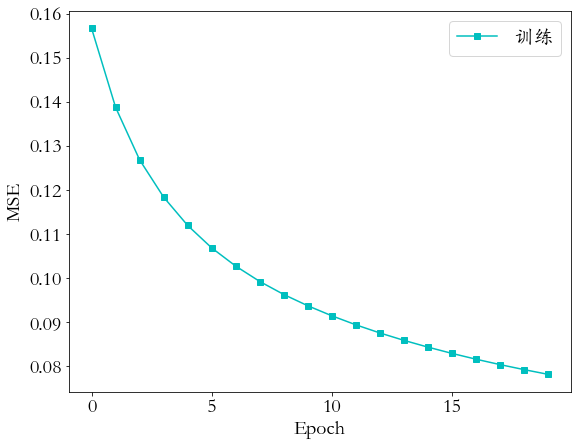

In [30]:
plt.figure()
plt.plot(losses, color='c', marker='s', label='训练')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('MSE')
plt.show()